# Introduction
In this challenge, Santander invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data they have available to solve this problem.

The data is anonimyzed, each row containing 200 numerical values identified just with a number.

In the following we will explore the data, prepare it for a model, train a model and predict the target value for the test set, then prepare a submission.

Stay tuned, I will frequently update this Kernel in the next days.

# Load packages

In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

# Load data

In [2]:
%%time
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Wall time: 26.9 s


# Data exploration
Let's check the train and test set

In [3]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

Both train and test data have 200,000 entries and 202, respectivelly 201 columns.

Let's glimpse train and test dataset.

In [4]:
train_df.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7   ...     var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266   ...      4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338   ...      7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155   ...      2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250   ...      4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514   ...     -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [5]:
test_df.head()

ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595   

     var_7   var_8   ...     var_190  var_191  var_192  var_193  var_194  \
0  18.2675  2.1337   ...     -2.1556  11.8495  -1.4300   2.4508  13.7112   
1  18.6316 -4.4131   ...     10.6165   8.8349   0.9403  10.1282  15.5765   
2  20.2537  1.5233   ...     -0.7484  10.9935   1.9803   2.1800  12.9813   
3  20.5660  3.3755   ...      9.5702   9.0766   1.6580   3.5813  15.1874   
4  10.6048  2.9890   ...      4.2259   9.1723   1.2835   3.3778  19.5542   

   var_195  var_196  var_197  var_198  var_199  
0   2.4669   4.3654  10.7200  15.4722  -8.7197  
1   0.4773  -1.4852   9.8714  19.1293 -20.9760  
2   2.1281  -7.1086   7.0618  19.8956 -23.1794  
3   3.1656   3.9567   9.2295  13.0168  -4.2108  
4  -0.2860  -5.1612   7.2882  13.9260  -9.1846  

[5 rows x 201 columns]

Train contains:
* ID_code (string)
* target
* 200 numerical variables, named from var_0 to var_199

Test contains:
* ID_code (string)
* 200 numerical variables, named from var_0 to var_199

Let's check if there are any missing data. We will also check the types of data.
We check the train data first.

In [6]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.shape[0]*100)
    
    tt = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [7]:
%%time
missing_data(train_df)

Wall time: 2.26 s


ID_code target    var_0    var_1    var_2    var_3    var_4    var_5  \
Total         0      0        0        0        0        0        0        0   
Percent       0      0        0        0        0        0        0        0   
Types    object  int64  float64  float64  float64  float64  float64  float64   

           var_6    var_7   ...     var_190  var_191  var_192  var_193  \
Total          0        0   ...           0        0        0        0   
Percent        0        0   ...           0        0        0        0   
Types    float64  float64   ...     float64  float64  float64  float64   

         var_194  var_195  var_196  var_197  var_198  var_199  
Total          0        0        0        0        0        0  
Percent        0        0        0        0        0        0  
Types    float64  float64  float64  float64  float64  float64  

[3 rows x 202 columns]

Here we check the test dataset

In [8]:
%%time
missing_data(test_df)

Wall time: 1.63 s


ID_code    var_0    var_1    var_2    var_3    var_4    var_5  \
Total         0        0        0        0        0        0        0   
Percent       0        0        0        0        0        0        0   
Types    object  float64  float64  float64  float64  float64  float64   

           var_6    var_7    var_8   ...     var_190  var_191  var_192  \
Total          0        0        0   ...           0        0        0   
Percent        0        0        0   ...           0        0        0   
Types    float64  float64  float64   ...     float64  float64  float64   

         var_193  var_194  var_195  var_196  var_197  var_198  var_199  
Total          0        0        0        0        0        0        0  
Percent        0        0        0        0        0        0        0  
Types    float64  float64  float64  float64  float64  float64  float64  

[3 rows x 201 columns]

There are no missing data in train and test datasets. Let's check the numerical values in train and test dataset.

In [9]:
%%time
train_df.describe()

Wall time: 5.35 s


target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8      ...              var_190  \
count  200000.000000  200000.000000      ...        200000.000000   
mean       16.545850       0.284162      ...             3.234440   
std         3.418076       3.332634      ...             4.559922   
min         5.349700     -10.505500      ...           -14.093300   
25%        13.943800      -2.317800      ...            -0.058825   
50%        16.456800       0.393700      ...             3.203600   
75%        19.102900       2.937900      ...             6.406200   
max        27.691800      10.151300      ...            18.440900   

             var_191        var_192        var_193        var_194  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        7.438408       1.927839       3.331774      17.993784   
std         3.023272       1.478423       3.992030       3.135162   
min        -2.691700      -3.814500     -11.783400       8.694400   
25%         5.157400       0.889775       0.584600      15.629800   
50%         7.347750       1.901300       3.396350      17.957950   
75%         9.512525       2.949500       6.205800      20.396525   
max        16.716500       8.402400      18.281800      27.928800   

             var_195        var_196        var_197        var_198  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -0.142088       2.303335       8.908158      15.870720   
std         1.429372       5.454369       0.921625       3.010945   
min        -5.261000     -14.209600       5.960600       6.299300   
25%        -1.170700      -1.946925       8.252800      13.829700   
50%        -0.172700       2.408900       8.888200      15.934050   
75%         0.829600       6.556725       9.593300      18.064725   
max         4.272900      18.321500      12.000400      26.079100   

             var_199  
count  200000.000000  
mean       -3.326537  
std        10.438015  
min       -38.852800  
25%       -11.208475  
50%        -2.819550  
75%         4.836800  
max        28.500700  

[8 rows x 201 columns]

In [10]:
%%time
test_df.describe()

Wall time: 5.88 s


var_0          var_1          var_2          var_3  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       10.658737      -1.624244      10.707452       6.788214   
std         3.036716       4.040509       2.633888       2.052724   
min         0.188700     -15.043400       2.355200      -0.022400   
25%         8.442975      -4.700125       8.735600       5.230500   
50%        10.513800      -1.590500      10.560700       6.822350   
75%        12.739600       1.343400      12.495025       8.327600   
max        22.323400       9.385100      18.714100      13.142000   

               var_4          var_5          var_6          var_7  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       11.076399      -5.050558       5.415164      16.529143   
std         1.616456       7.869293       0.864686       3.424482   
min         5.484400     -27.767000       2.216400       5.713700   
25%         9.891075     -11.201400       4.772600      13.933900   
50%        11.099750      -4.834100       5.391600      16.422700   
75%        12.253400       0.942575       6.005800      19.094550   
max        16.037100      17.253700       8.302500      28.292800   

               var_8          var_9      ...              var_190  \
count  200000.000000  200000.000000      ...        200000.000000   
mean        0.277135       7.569407      ...             3.189766   
std         3.333375       1.231865      ...             4.551239   
min        -9.956000       4.243300      ...           -14.093300   
25%        -2.303900       6.623800      ...            -0.095000   
50%         0.372000       7.632000      ...             3.162400   
75%         2.930025       8.584825      ...             6.336475   
max         9.665500      11.003600      ...            20.359000   

             var_191        var_192        var_193        var_194  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        7.458269       1.925944       3.322016      17.996967   
std         3.025189       1.479966       3.995599       3.140652   
min        -2.407000      -3.340900     -11.413100       9.382800   
25%         5.166500       0.882975       0.587600      15.634775   
50%         7.379000       1.892600       3.428500      17.977600   
75%         9.531100       2.956000       6.174200      20.391725   
max        16.716500       8.005000      17.632600      27.947800   

             var_195        var_196        var_197        var_198  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       -0.133657       2.290899       8.912428      15.869184   
std         1.429678       5.446346       0.920904       3.008717   
min        -4.911900     -13.944200       6.169600       6.584000   
25%        -1.160700      -1.948600       8.260075      13.847275   
50%        -0.162000       2.403600       8.892800      15.943400   
75%         0.837900       6.519800       9.595900      18.045200   
max         4.545400      15.920700      12.275800      26.538400   

             var_199  
count  200000.000000  
mean       -3.246342  
std        10.398589  
min       -39.457800  
25%       -11.124000  
50%        -2.725950  
75%         4.935400  
max        27.907400  

[8 rows x 200 columns]

We can make a few observations here:
* standard deviation is relatively large for both train and test variable data
* min, max, mean, std values for train an test data looks quite close
* mean values are distributed over a large range.

The number of values in train and test set is the same. Let's plot the scatter plot for train and test set for a few of the features.

In [11]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(4, 4, figsize=(14,14))
    
    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker = '+')
        plt.xlabel(feature, fontsize=9)
    plt.show()

We will show just 5% of the data. On x axis we show train values and on the y axis we show the test values.

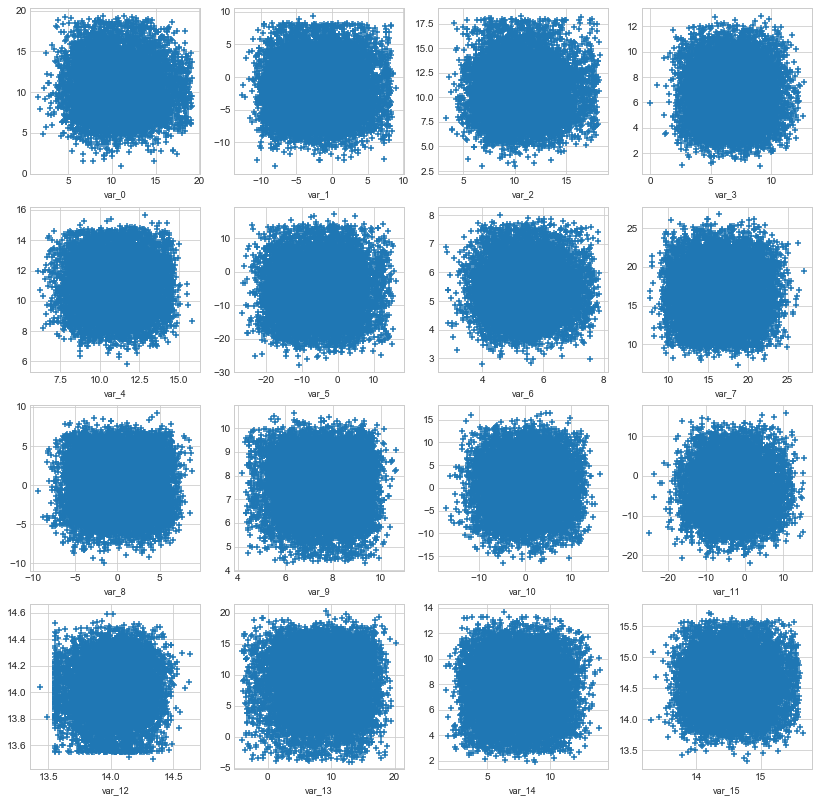

In [12]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train_df[::20],test_df[::20], features)

Let's check the distribution of the target variable in the train dataset.

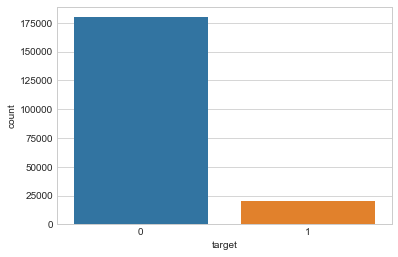

In [13]:
sns.countplot(train_df['target'])

In [14]:
print('There are {}% target values with 1'.format(100 * train_df['target'].value_counts()[1]/
                                                 train_df.shape[0]))

There are 10.049% target values with 1


The data in unbalanced with respect to the target value.

# Density plots of features

Let's show now the density plot of variables in train dataset.

We represent with different colors the distribution for values with target value 0 and 1.

In [15]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,5,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,5,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

The first 50 values are displayed in the following cell

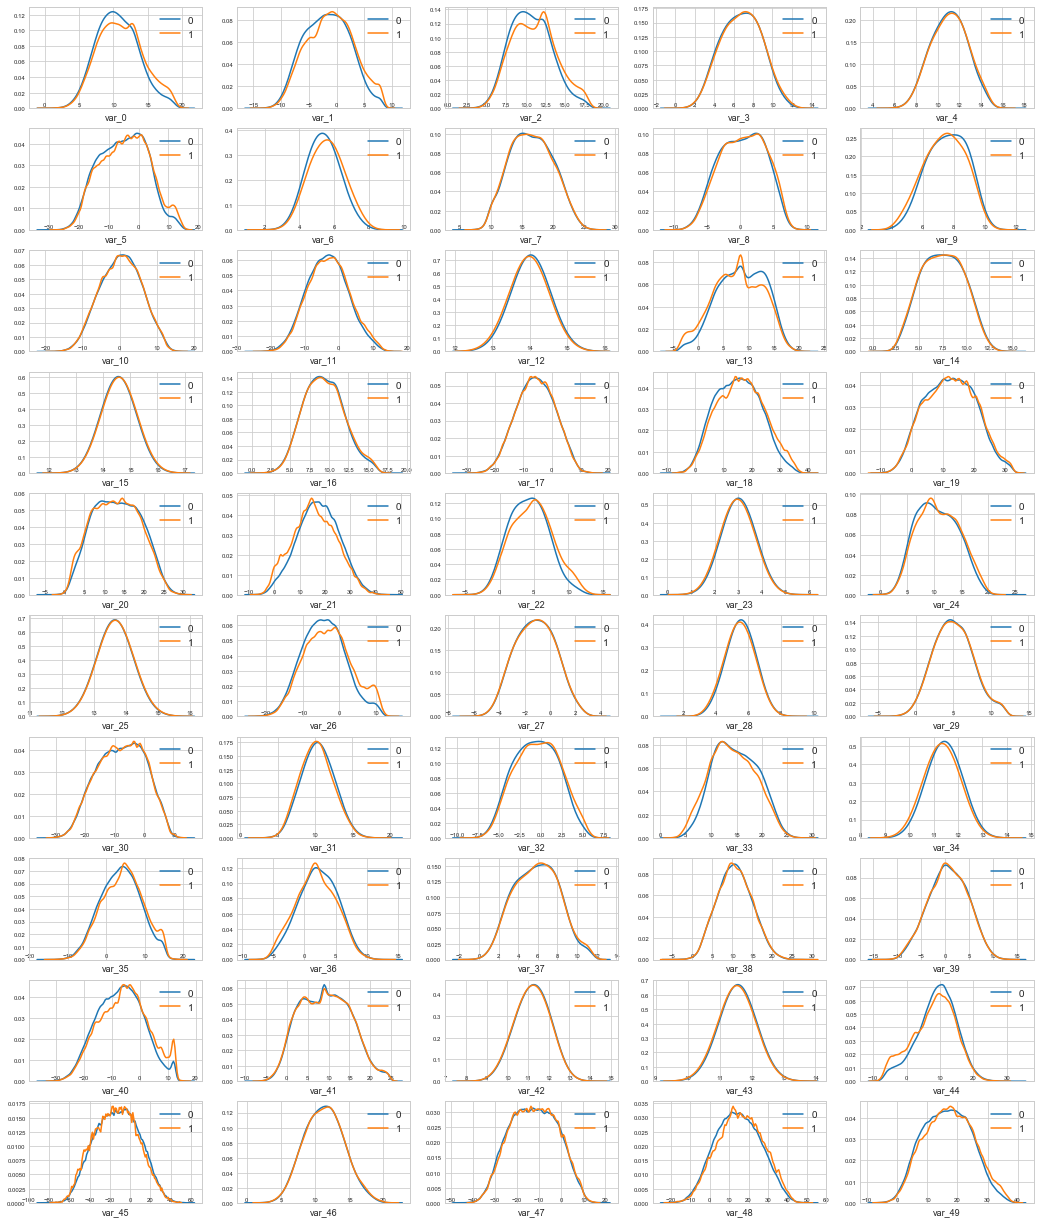

In [16]:
t0 = train_df.loc[train_df['target']==0]
t1 = train_df.loc[train_df['target']==1]
features = train_df.columns.values[2:52]
plot_feature_distribution(t0, t1, '0', '1', features)

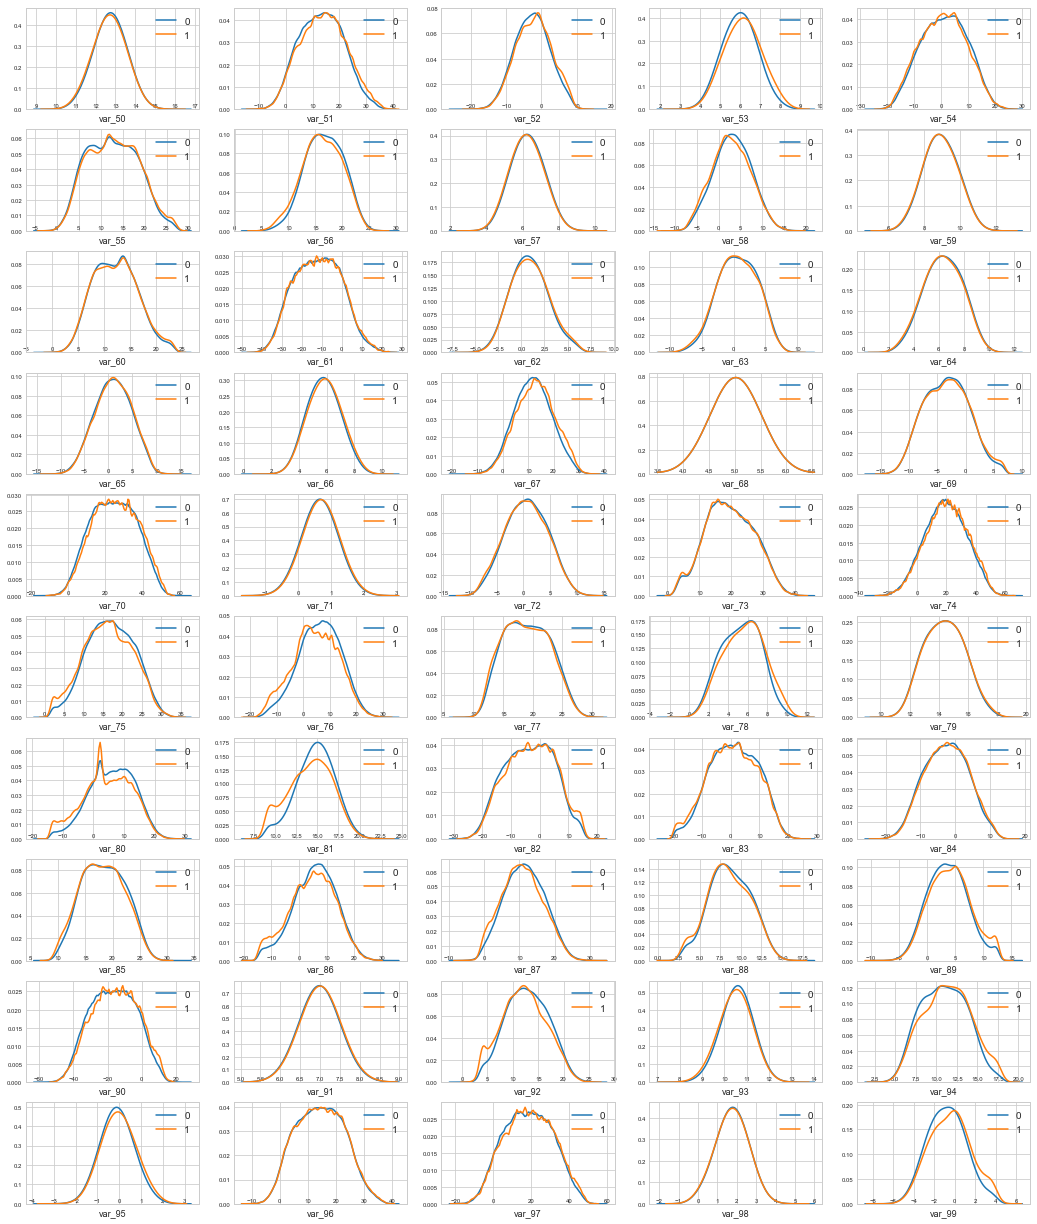

In [17]:
t0 = train_df.loc[train_df['target']==0]
t1 = train_df.loc[train_df['target']==1]
features = train_df.columns.values[52:102]
plot_feature_distribution(t0, t1, '0', '1', features)

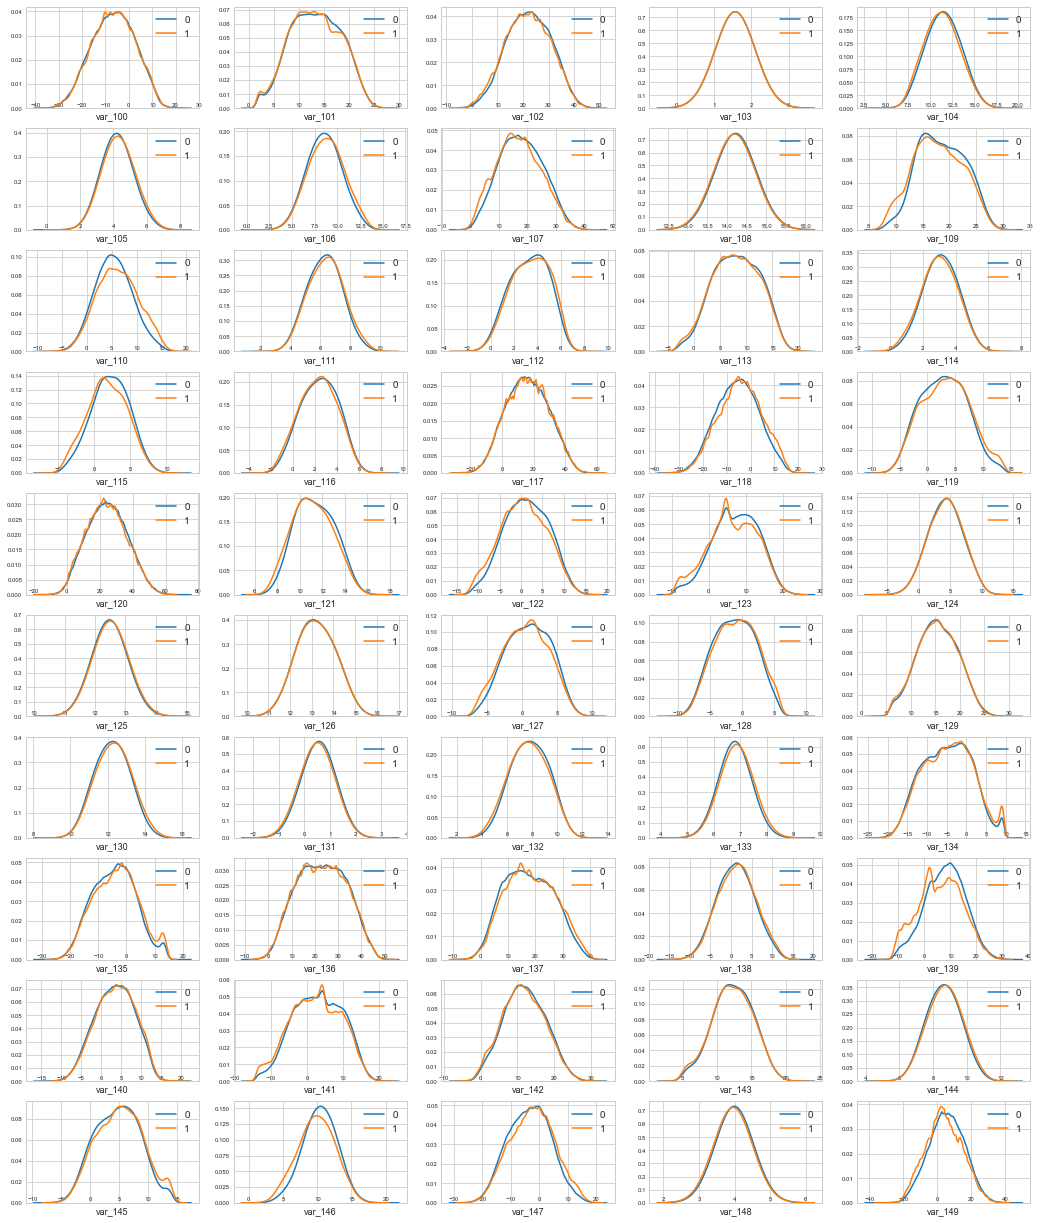

In [18]:
t0 = train_df.loc[train_df['target']==0]
t1 = train_df.loc[train_df['target']==1]
features = train_df.columns.values[102:152]
plot_feature_distribution(t0, t1, '0', '1', features)

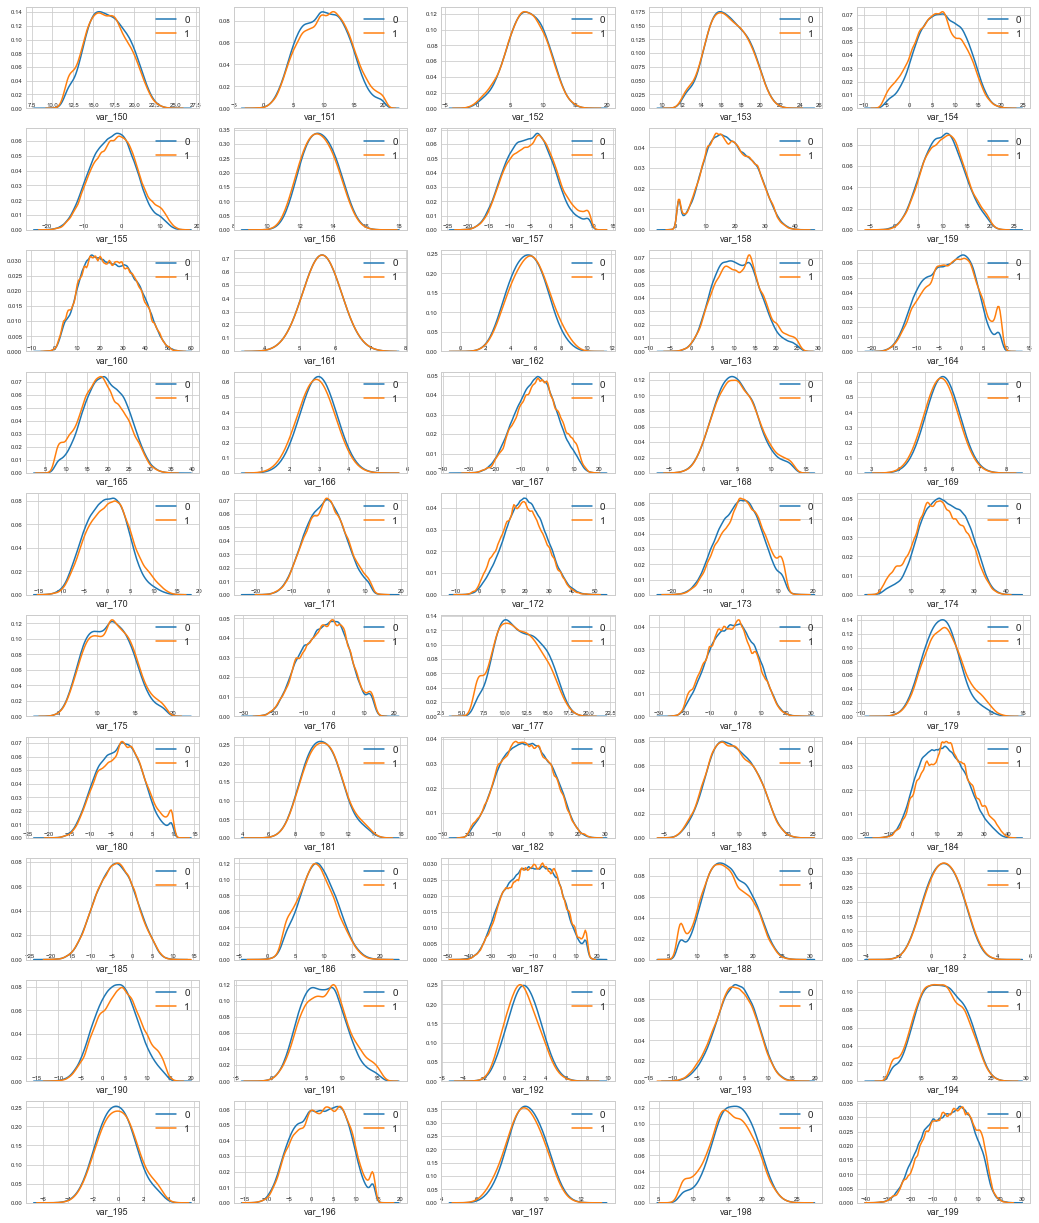

In [19]:
t0 = train_df.loc[train_df['target']==0]
t1 = train_df.loc[train_df['target']==1]
features = train_df.columns.values[152:202]
plot_feature_distribution(t0, t1, '0', '1', features)

We can observe that there is a considerable number of feature with significant differente distribution for the two target values.
For example, var_0, var_1, var_2, var_5, var_9, var_13, var_16, var_109, var_139 and many others.

Also some features, like var_2, var_13, var_26, var_55, var_175, var_184, var_196 shows a distribution that resambles to a bivariate distribution.

We will take this into consideration in the feature selection part.

Let's now look to the distribution of the same features in parallel in train and test datasets

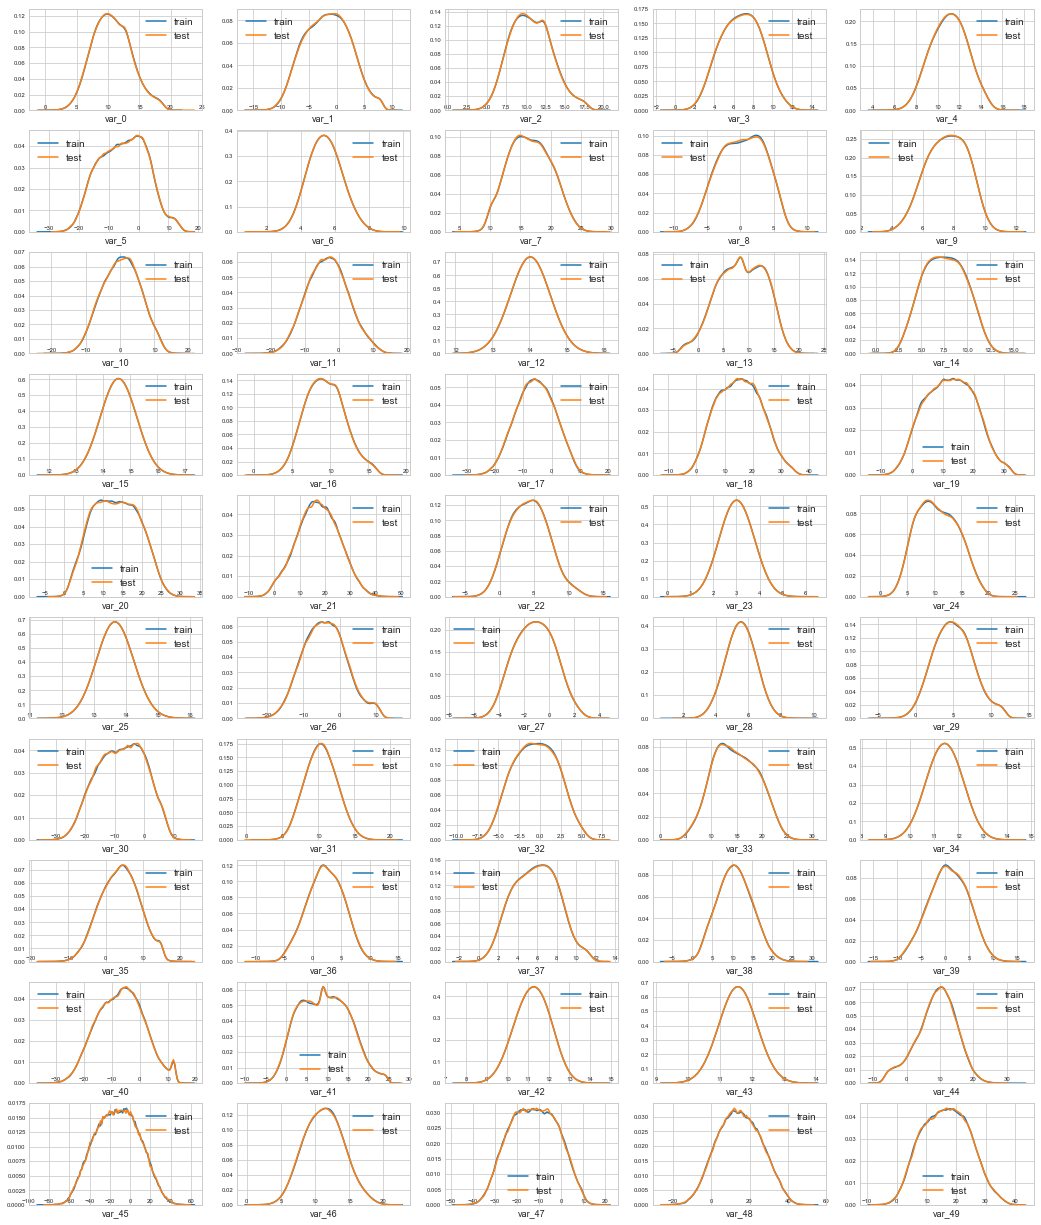

In [20]:
features = train_df.columns.values[2:52]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

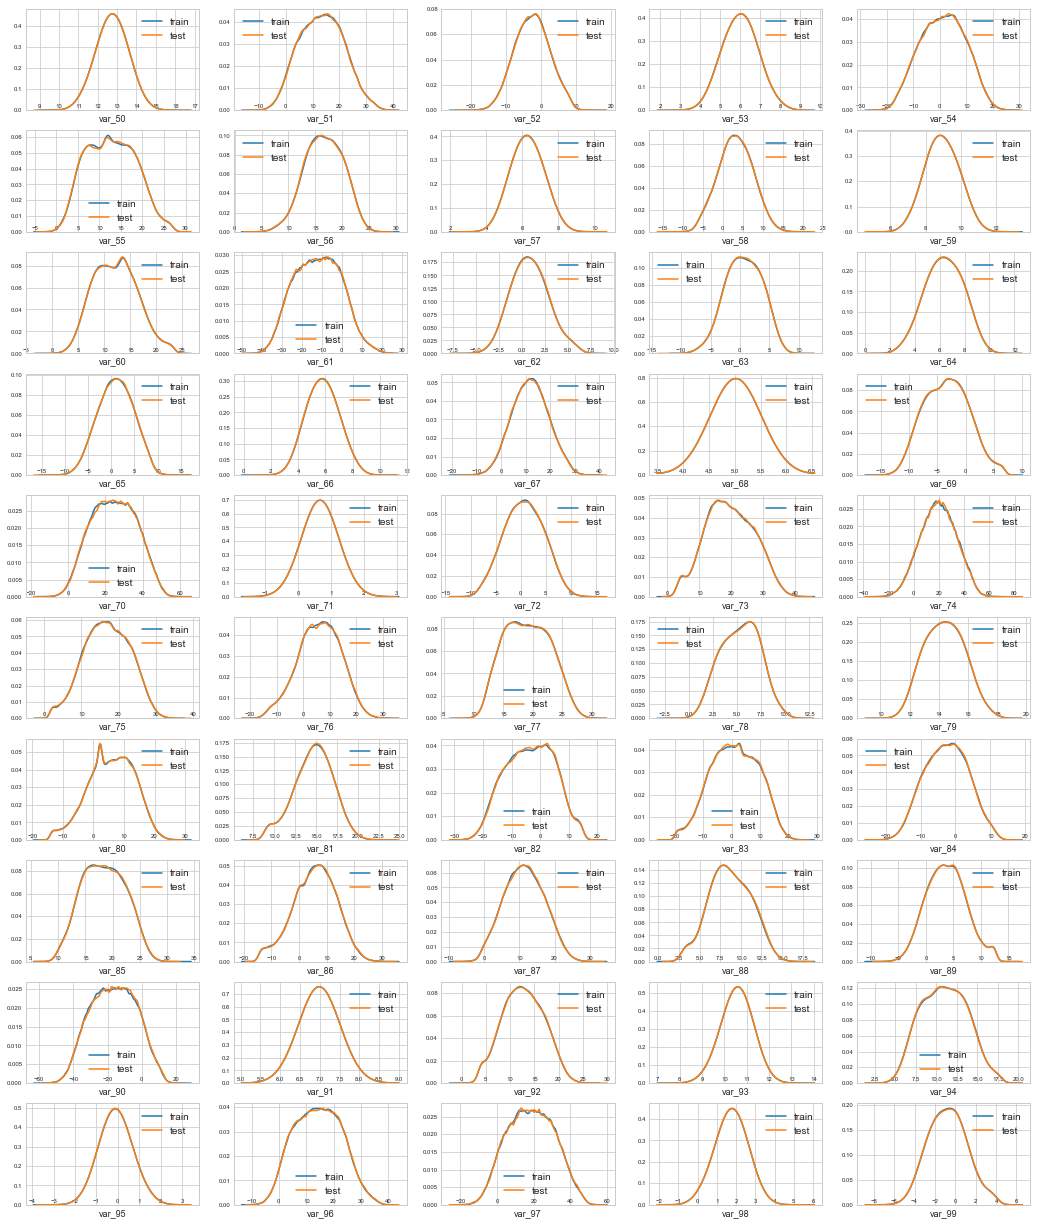

In [21]:
features = train_df.columns.values[52:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

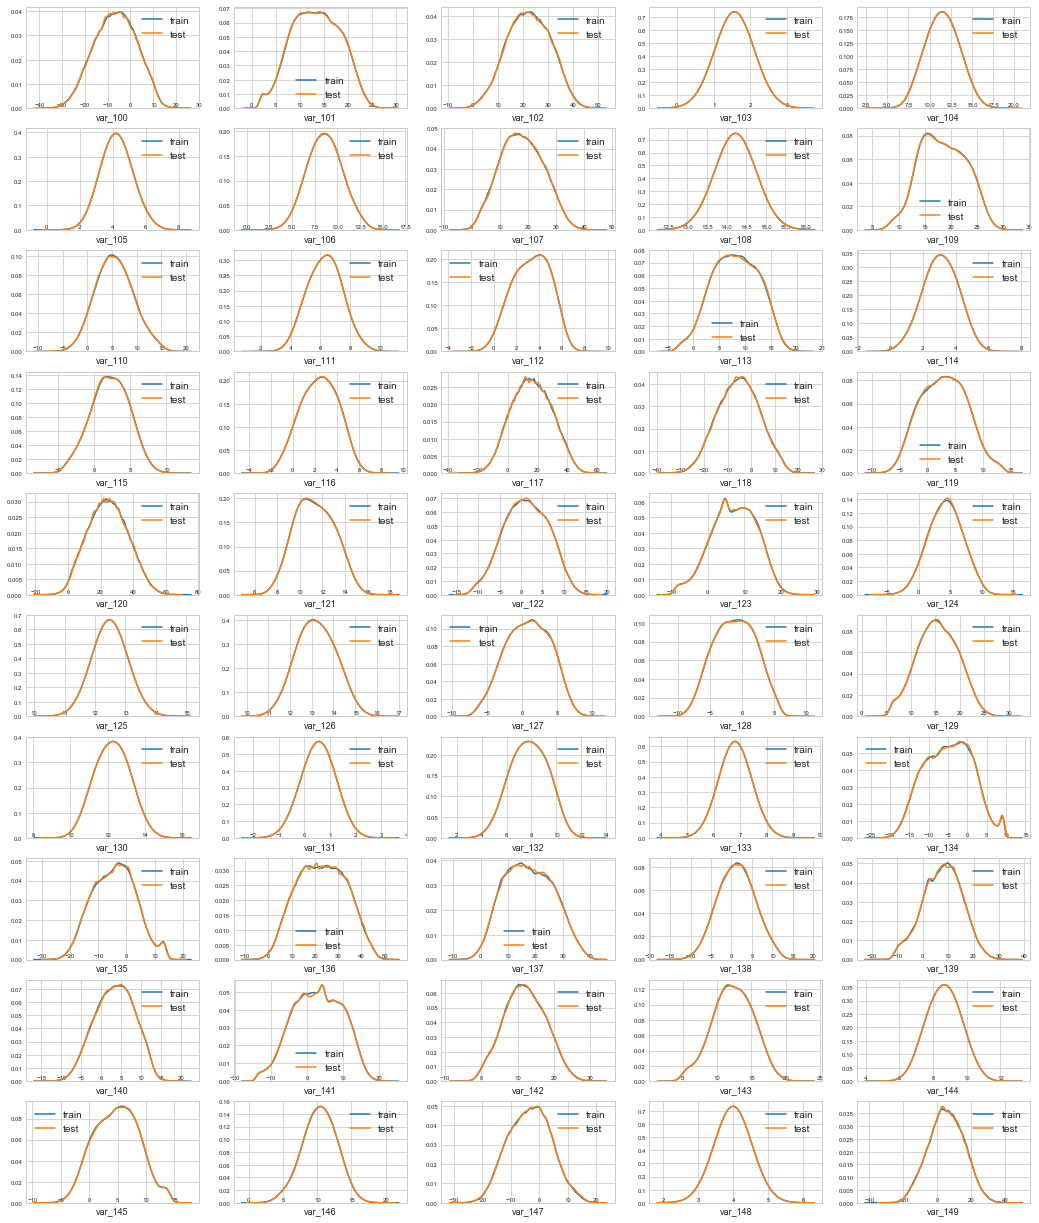

In [22]:
features = train_df.columns.values[102:152]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

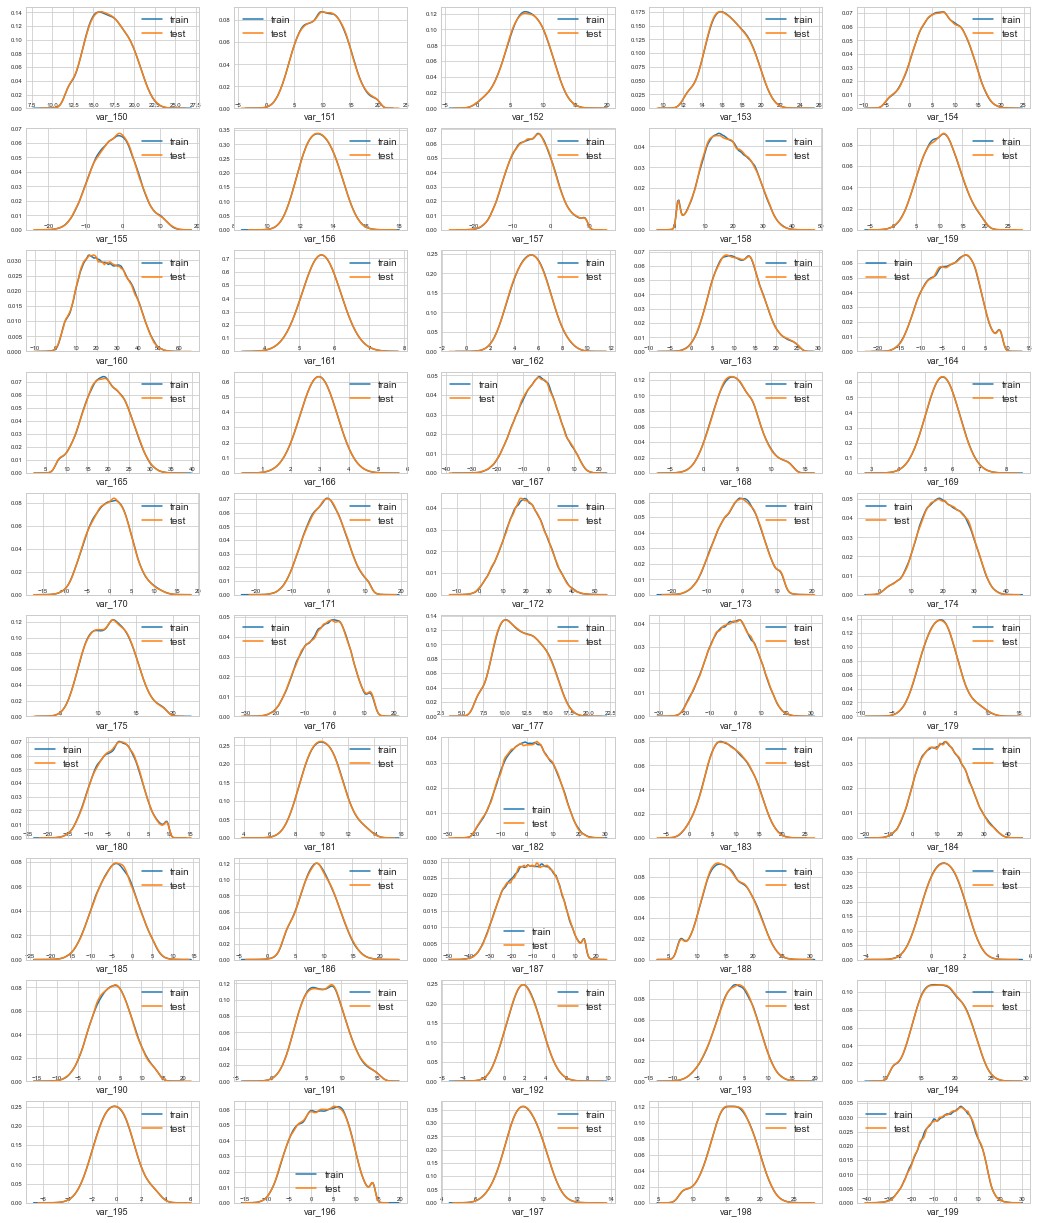

In [23]:
features = train_df.columns.values[152:202]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

The train and test seems to be well balanced with respect to the distribution of the numeric variables

# Distribution of mean and std

Let's check the distribution of the mean values per row in the train and test set

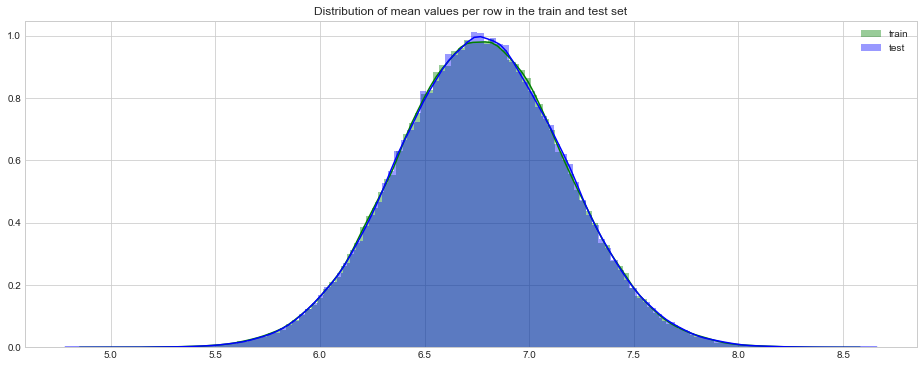

In [24]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of mean values per row in the train and test set')
sns.distplot(train_df[features].mean(axis=1), color = 'green', kde=True, bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1), color = 'blue', kde=True, bins=120, label='test')
plt.legend()
plt.show()

Let's check the distribution of the mean values per columns in the train and test set

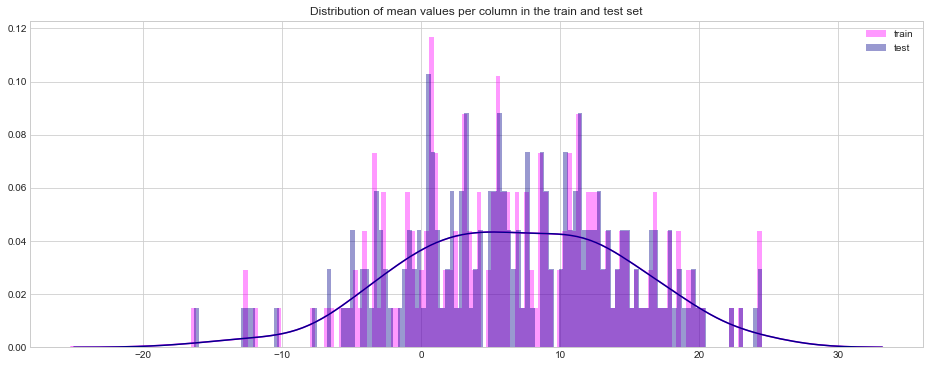

In [25]:
plt.figure(figsize=(16,6))
plt.title('Distribution of mean values per column in the train and test set')
sns.distplot(train_df[features].mean(axis=0), color='magenta', kde=True, bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0), color='darkblue', kde=True, bins=120, label='test')
plt.legend()
plt.show()

Let's show the distribution of standard deviation of values per row for train and test datasets

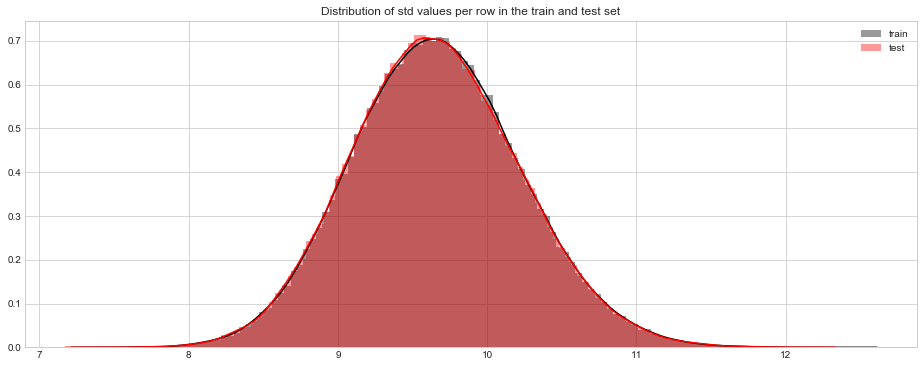

In [26]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

Let's check the distribution of the standard deviation of values per columns in the train and test datasets.

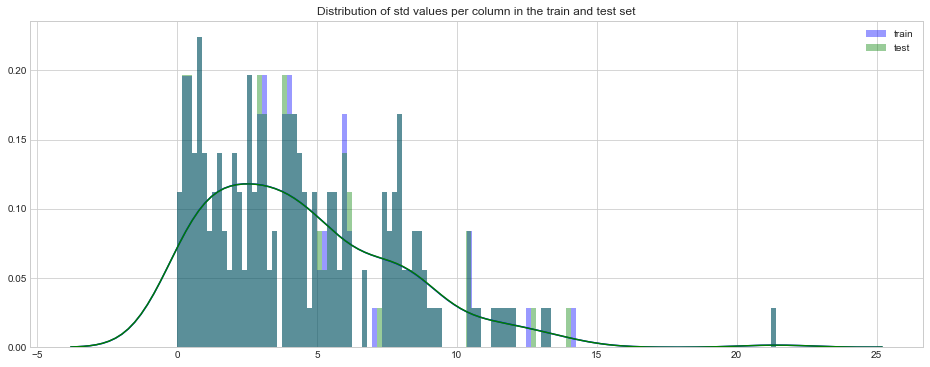

In [27]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

Let's check now the distribution of the mean value pero row in the train dataset, grouped by value of target

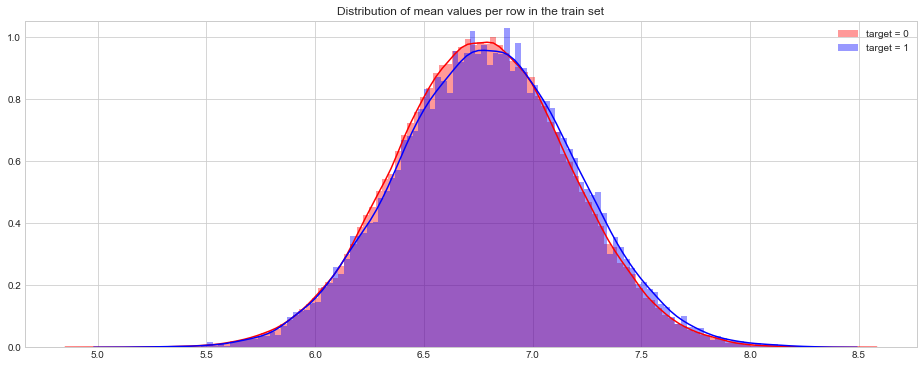

In [28]:
t0 = train_df.loc[train_df['target']==0]
t1 = train_df.loc[train_df['target']==1]
plt.figure(figsize=(16,6))
plt.title('Distribution of mean values per row in the train set')
sns.distplot(t0[features].mean(axis=1), color='red', kde=True, bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1), color='blue', kde=True, bins=120, label='target = 1')
plt.legend()
plt.show()

Let's check now the distribution of the mean value per column in the train dataset, grouped by value of target.

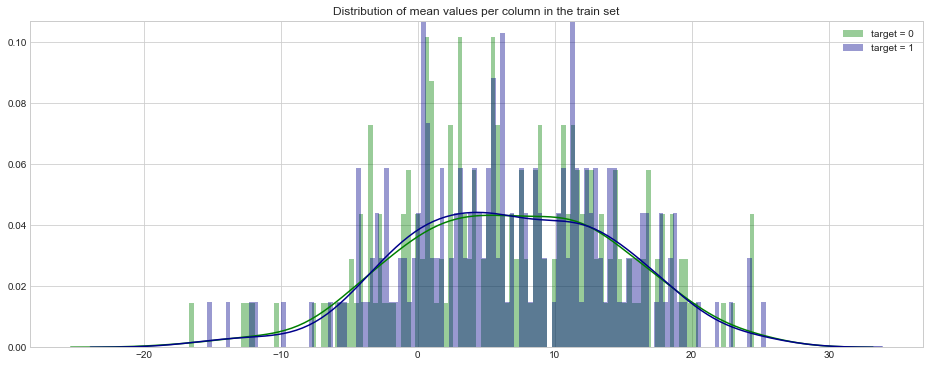

In [29]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# Distribution of min and max
Let's check the distribution of min per row in the train set and test set

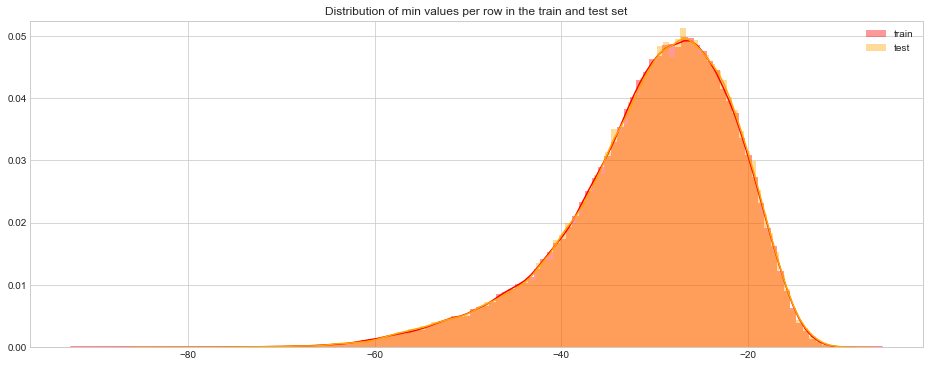

In [30]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train_df[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

A long queue to the lower values for both, extended as long as to -80 for test set, is observed.

Let's now show the distribution of min per column in the train and test set.

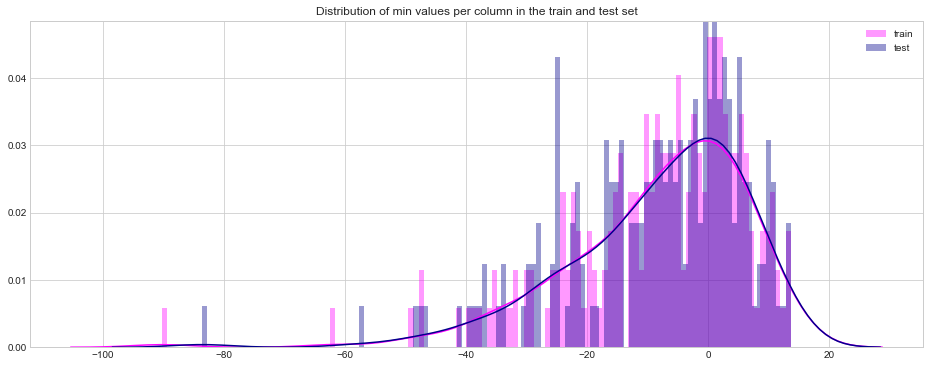

In [31]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train_df[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's check now the distribution of max values per rows for train and test set.

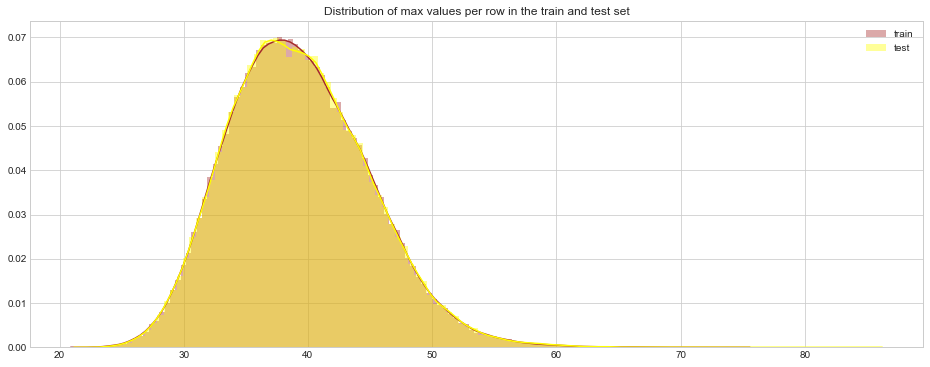

In [32]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train_df[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's show now the max distribution on columns for train and test set.

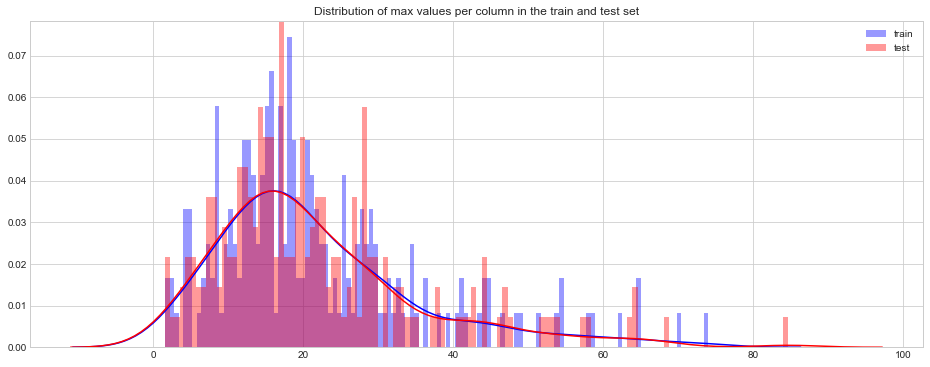

In [33]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train_df[features].max(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Let's show now the distributions of min values per row in train set, separated on the values of target (0 and 1).

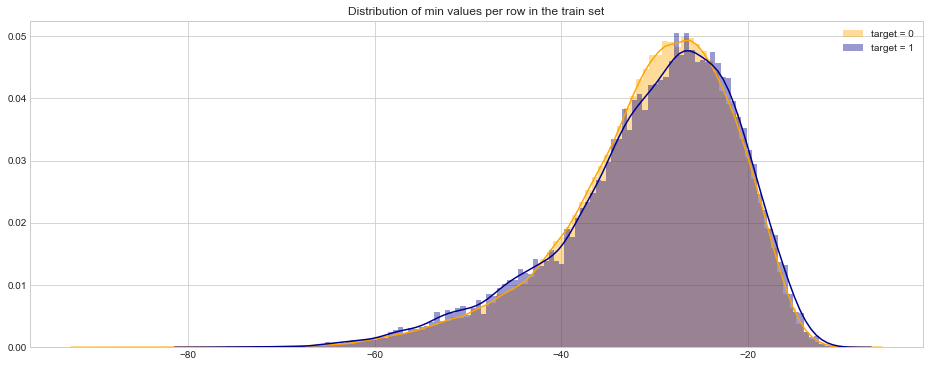

In [34]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

We show here the distribution of min values per columns in train set.

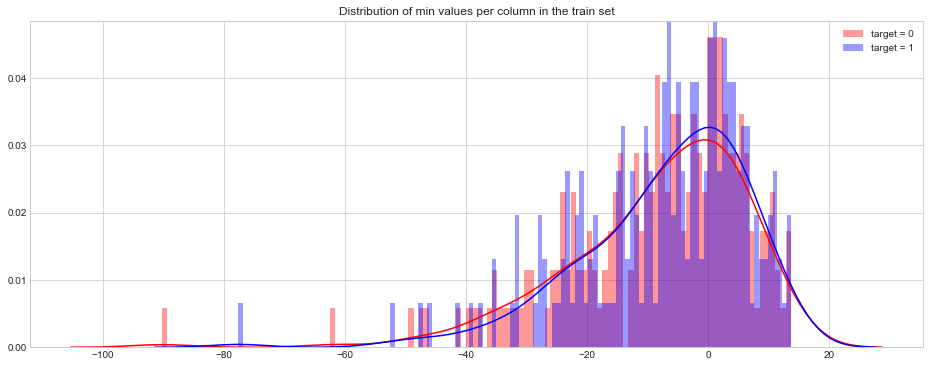

In [35]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's show now the distribution of max values per rown in the train set.

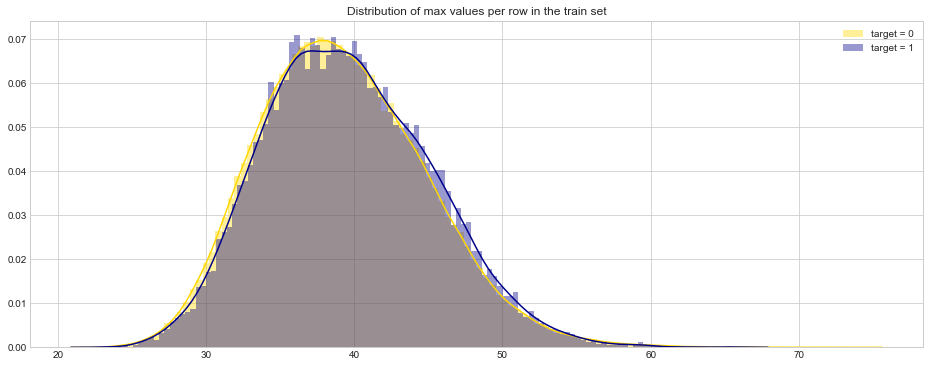

In [36]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's show also the distribution of max values per columns in the train set.

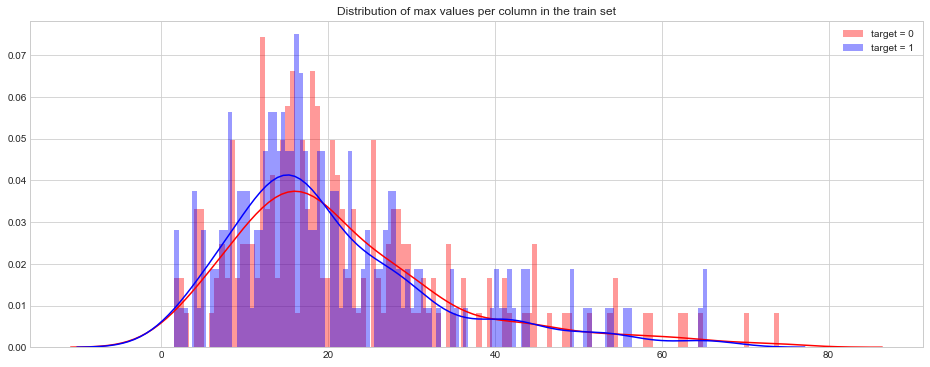

In [37]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# Features correlation
We calculate now the correlations between the features in train set.
The following table shows the first 10 least correlated features.

In [38]:
%%time
correlations = train_df[features].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
correlations = correlations[correlations['level_0']!=correlations['level_1']]
correlations.head(10)

Wall time: 38.2 s


Let's look to the top most correlated features, besides the same feature pairs.

In [39]:
correlations.tail(10)

level_0  level_1         0
39790  var_183  var_189  0.009359
39791  var_189  var_183  0.009359
39792  var_174   var_81  0.009490
39793   var_81  var_174  0.009490
39794   var_81  var_165  0.009714
39795  var_165   var_81  0.009714
39796   var_53  var_148  0.009788
39797  var_148   var_53  0.009788
39798   var_26  var_139  0.009844
39799  var_139   var_26  0.009844

Let's see also the least correlated features.

In [40]:
correlations.head(10)

level_0  level_1             0
0   var_75  var_191  2.703975e-08
1  var_191   var_75  2.703975e-08
2  var_173    var_6  5.942735e-08
3    var_6  var_173  5.942735e-08
4  var_126  var_109  1.313947e-07
5  var_109  var_126  1.313947e-07
6  var_144   var_27  1.772502e-07
7   var_27  var_144  1.772502e-07
8  var_177  var_100  3.116544e-07
9  var_100  var_177  3.116544e-07

The correlation between the features is very small

# Duplicate values
Let's now check how many duplicate values exist per columns.

In [41]:
%%time
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

Wall time: 12.4 s


Let's show the top 15 max of duplicate values per train set.

In [42]:
pd.DataFrame(unique_max_train, columns = ['Feature', "Max duplicates", 'Value']).sort_values(
by = 'Max duplicates', ascending=False).head(15)

Feature  Max duplicates    Value
68    var_68            1084   5.0214
108  var_108             313  14.1999
126  var_126             305  11.5356
12    var_12             203  13.5545
91    var_91              66   6.9785
103  var_103              61   1.6662
148  var_148              59   4.0456
71    var_71              54   0.7031
161  var_161              52   5.7688
25    var_25              41  13.6723
125  var_125              40  12.5159
169  var_169              39   5.6941
166  var_166              39   2.7306
133  var_133              39   6.8632
43    var_43              39  11.4522

Let's see also the top 15 number of duplicates values per test set.

In [43]:
pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value']).\
            sort_values(by = 'Max duplicates', ascending=False).head(15)

Feature  Max duplicates    Value
68    var_68            1104   5.0197
126  var_126             307  11.5357
108  var_108             302  14.1999
12    var_12             188  13.5546
91    var_91              86   6.9939
103  var_103              78   1.4659
148  var_148              74   4.0004
161  var_161              69   5.7114
25    var_25              60  13.5965
71    var_71              60   0.5389
43    var_43              58  11.5738
166  var_166              53   2.8446
125  var_125              53  12.2189
169  var_169              51   5.8455
133  var_133              50   6.6873

Same columns in train and test set have the same or very close number of duplicates of same or very close values. This is an interesting pattern that we might be able to use in the future.

# Feature engineering

This section is under contruction

Let's calculate for starting few aggregated values for the existing feature.

In [4]:
%%time
i = 1
for df in [test_df, train_df]:
    idx = df.columns.values[i:i+200]
    df['sum'] = df[idx].sum(axis=1)
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)
    i = i + 1

Wall time: 13.8 s


Let's check the new created features

In [45]:
train_df[train_df.columns[202:]].head()

sum      min      max      mean        std      skew      kurt  \
0  1456.3182 -21.4494  43.1127  7.281591   9.331540  0.101580  1.331023   
1  1415.3636 -47.3797  40.5632  7.076818  10.336130 -0.351734  4.110215   
2  1240.8966 -22.4038  33.8820  6.204483   8.753387 -0.056957  0.546438   
3  1288.2319 -35.1659  38.1015  6.441159   9.594064 -0.480116  2.630499   
4  1354.2310 -65.4863  41.1037  6.771155  11.287122 -1.463426  9.787399   

       med  
0  6.77040  
1  7.22315  
2  5.89940  
3  6.70260  
4  6.94735

In [46]:
test_df[test_df.columns[201:]].head()

sum      min      max      mean        std      skew      kurt  \
0  1416.6404 -31.9891  42.0248  7.083202   9.910632 -0.088518  1.871262   
1  1249.6860 -41.1924  35.6020  6.248430   9.541267 -0.559785  3.391068   
2  1430.2599 -34.3488  39.3654  7.151299   9.967466 -0.135084  2.326901   
3  1411.4447 -21.4797  40.3383  7.057223   8.257204 -0.167741  2.253054   
4  1423.7364 -24.8254  45.5510  7.118682  10.043542  0.293484  2.044943   

       med  
0  7.31440  
1  6.43960  
2  7.26355  
3  6.89675  
4  6.83375

Let's check the distribution of these new, engineered features.

We plot first the distribution of new features, grouped by value of corresponding target values.

In [47]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

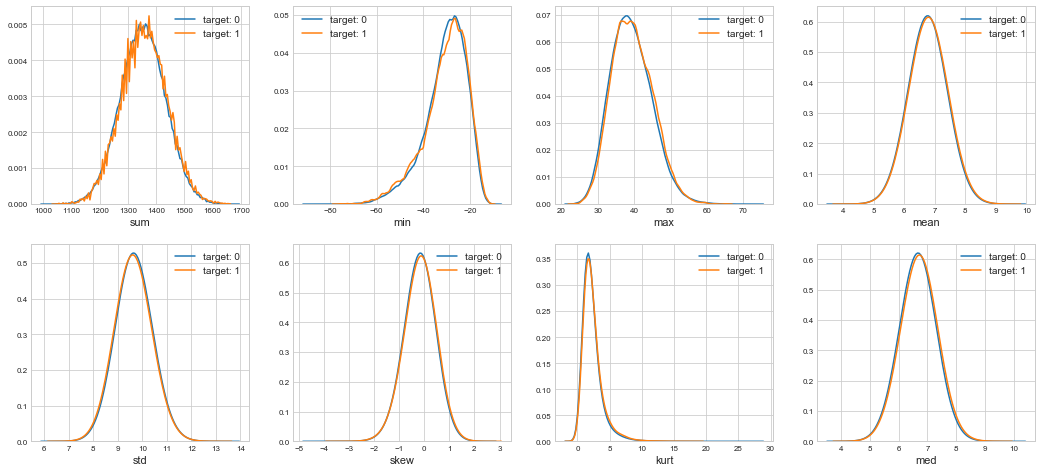

In [48]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

Let's show the distribution of new features values for train and test.

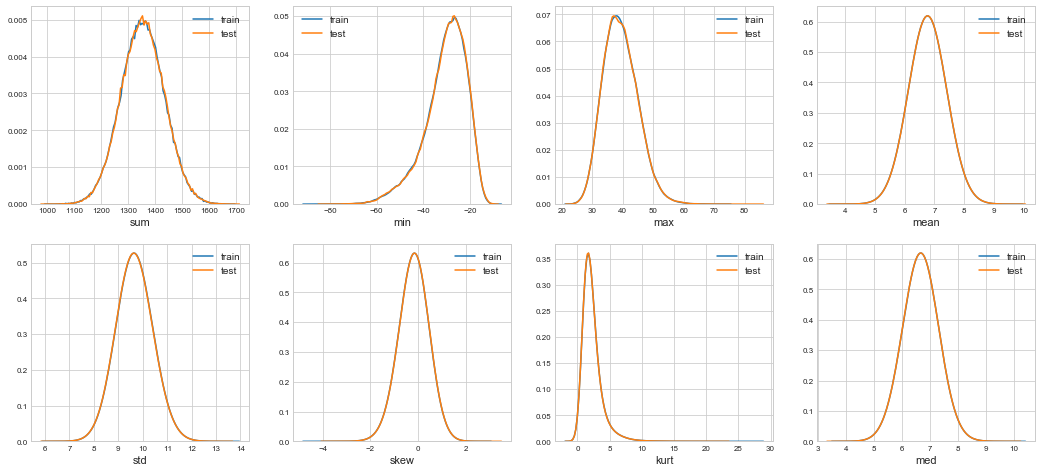

In [49]:
features = train_df.columns.values[202:]
plot_new_feature_distribution(train_df, test_df, 'train', 'test', features)

We add rounded features.
Note: this is a work in progress, some of the features added here will be later dropped.

In [50]:
#features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
#for feature in features:
#train_df['r2_'+feature] = np.round(train_df[feature], 2)
#test_df['r2_'+feature] = np.round(test_df[feature], 2)
#train_df['r1_'+feature] = np.round(train_df[feature], 1)
#test_df['r1_'+feature] = np.round(test_df[feature], +1)

Let's check how many features we have now.

In [51]:
print('Train and test columns: {} {}'.format(len(train_df.columns), len(test_df.columns)))

Train and test columns: 210 209


# Model
From the train columns list, we drop the ID and target to form the features list.

In [52]:
features = [c for c in train_df.columns if c not in ['ID_code','target']]
target = train_df['target']

We define the hyperparameters for the model.

In [53]:
param = {
        'num_leaves': 6,
        'max_bin': 63,
        'min_data_in_leaf': 45,
        'learning_rate': 0.01,
        'min_sum_hessian_in_leaf': 0.000446,
        'bagging_fraction': 0.55, 
        'bagging_freq': 5, 
        'max_depth': 14,
        'save_binary': True,
        'seed': 31452,
        'feature_fraction_seed': 31415,
        'feature_fraction': 0.51,
        'bagging_seed': 31415,
        'drop_seed': 31415,
        'data_random_seed': 31415,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
        'nthread' : 4
    }

We run the model.

In [54]:
%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=31415)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 15000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 250)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.863172	valid_1's auc: 0.847699
[2000]	training's auc: 0.891477	valid_1's auc: 0.872558
[3000]	training's auc: 0.904518	valid_1's auc: 0.883441
[4000]	training's auc: 0.912405	valid_1's auc: 0.889064
[5000]	training's auc: 0.917619	valid_1's auc: 0.892495
[6000]	training's auc: 0.921564	valid_1's auc: 0.89462
[7000]	training's auc: 0.924915	valid_1's auc: 0.896013
[8000]	training's auc: 0.927889	valid_1's auc: 0.89678
Early stopping, best iteration is:
[8316]	training's auc: 0.928879	valid_1's auc: 0.896936
Fold 1
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.863263	valid_1's auc: 0.847759
[2000]	training's auc: 0.891265	valid_1's auc: 0.872598
[3000]	training's auc: 0.90442	valid_1's auc: 0.883038
[4000]	training's auc: 0.91229	valid_1's auc: 0.888896
[5000]	training's auc: 0.917622	valid_1's auc: 0.892049
[6000]	training's auc: 0.921594	valid_1's auc

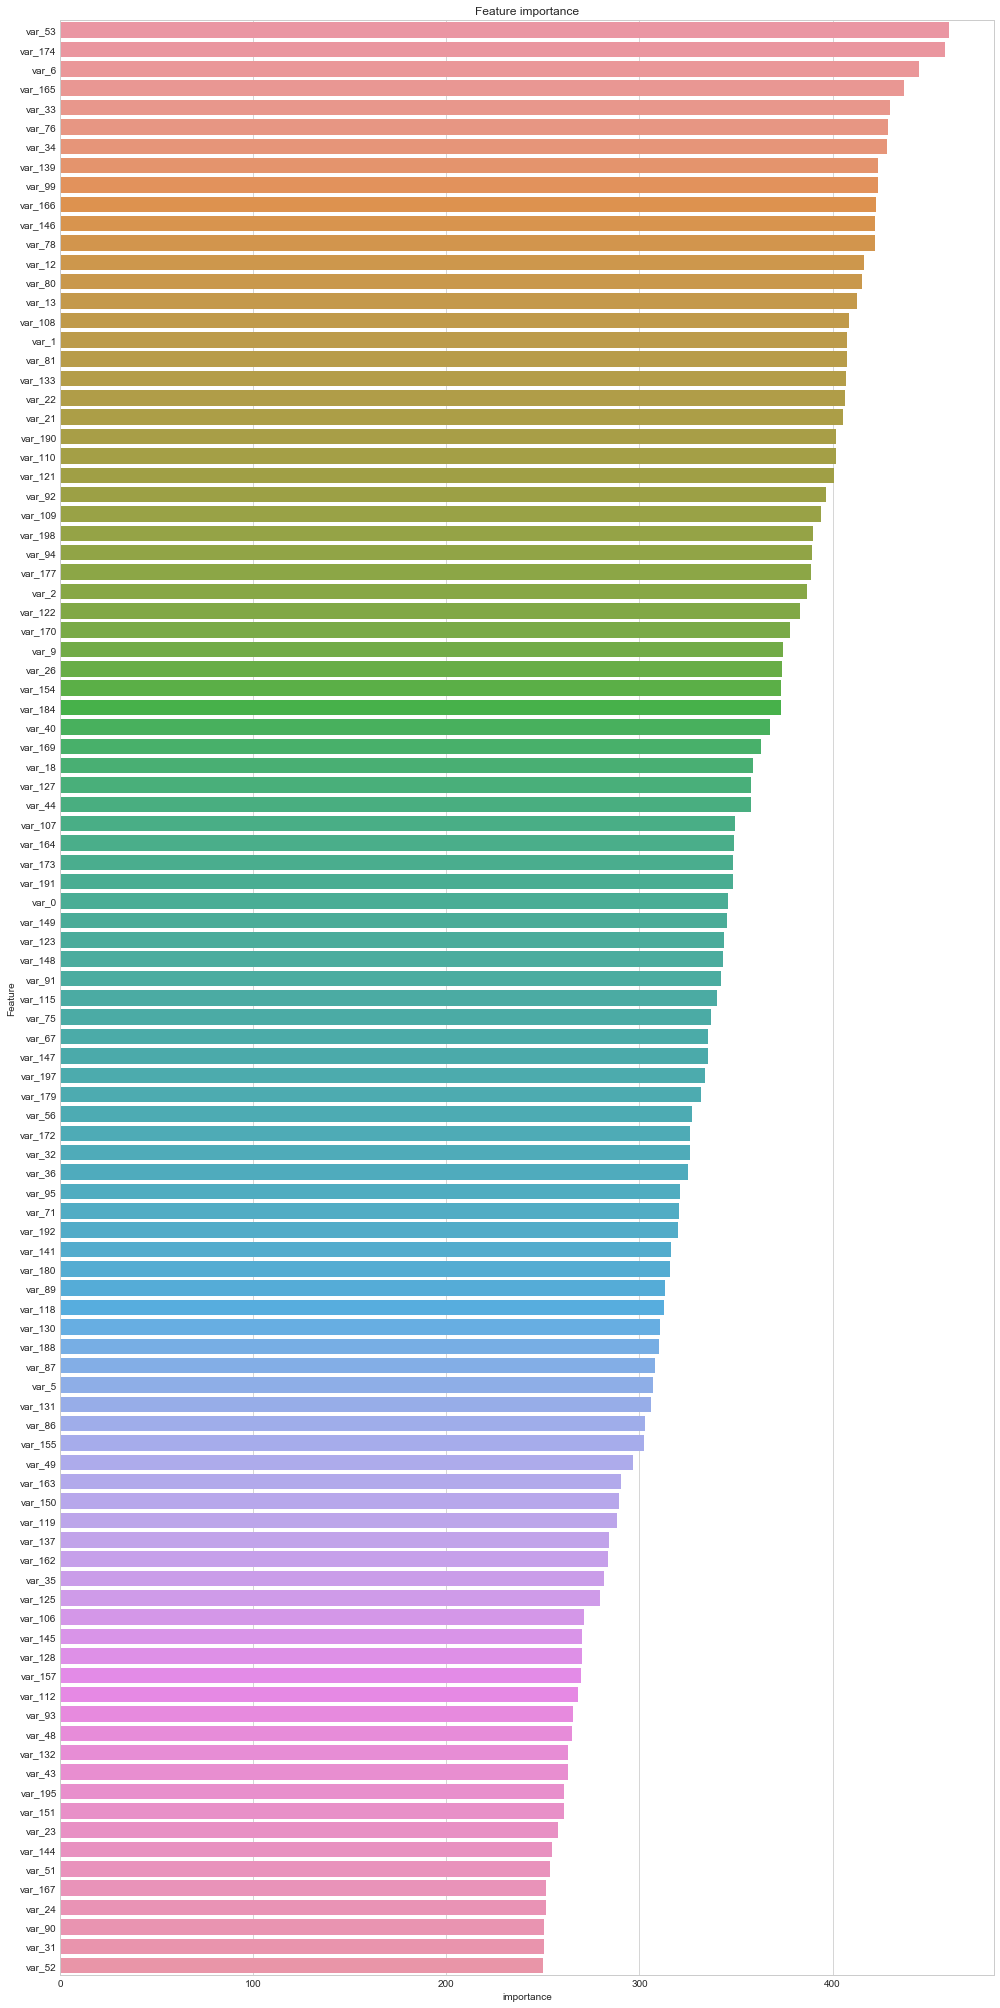

In [55]:
figure = feature_importance_df[['Feature', 'importance']].groupby('Feature').mean().sort_values(
by='importance', ascending=False).reset_index().loc[0:100,]
plt.figure(figsize=(14,28))
sns.barplot('importance','Feature',data=figure.sort_values('importance',ascending=False))
plt.title('Feature importance')
plt.tight_layout()

In [56]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

In [5]:
# featuretools for automated feature engineering
import featuretools as ft
print(train_df.shape)
data = pd.concat([train_df,test_df],axis=0)
# Entity set with id applications
es = ft.EntitySet(id = 'clients')
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'train', dataframe = data, index = 'ID_code')

(200000, 210)


In [6]:
es

Entityset: clients
  Entities:
    train [Rows: 400000, Columns: 210]
  Relationships:
    No relationships

In [108]:
primitives = ft.list_primitives()
primitives[primitives['type']=='transform']

name       type  \
19                 isin  transform   
20                 week  transform   
21               negate  transform   
22            haversine  transform   
23                 days  transform   
24              weekend  transform   
25            longitude  transform   
26              minutes  transform   
27             subtract  transform   
28             latitude  transform   
29           characters  transform   
30                 year  transform   
31            cum_count  transform   
32                  day  transform   
33              weekday  transform   
34                 hour  transform   
35                  and  transform   
36               minute  transform   
37              cum_max  transform   
38              seconds  transform   
39                years  transform   
40  time_since_previous  transform   
41              cum_min  transform   
42                  mod  transform   
43             absolute  transform   
44              is_null  transform   
45             cum_mean  transform   
46           percentile  transform   
47                hours  transform   
48               divide  transform   
49               second  transform   
50                weeks  transform   
51                   or  transform   
52           time_since  transform   
53                 diff  transform   
54               months  transform   
55             multiply  transform   
56              cum_sum  transform   
57                  not  transform   
58           days_since  transform   
59                  add  transform   
60             numwords  transform   
61                month  transform   

                                          description  
19  For each value of the base feature, checks whe...  
20        Transform a Datetime feature into the week.  
21  Creates a transform feature that negates a fea...  
22  Calculate the approximate haversine distance i...  
23  Transform a Timedelta feature into the number ...  
24  Transform Datetime feature into the boolean of...  
25  Returns the second value on the tuple base fea...  
26  Transform a Timedelta feature into the number ...  
27  Creates a transform feature that subtracts two...  
28  Returns the first value of the tuple base feat...  
29           Return the characters in a given string.  
30        Transform a Datetime feature into the year.  
31  Calculates the number of previous values of an...  
32         Transform a Datetime feature into the day.  
33  Transform Datetime feature into the boolean of...  
34        Transform a Datetime feature into the hour.  
35  For two boolean values, determine if both valu...  
36      Transform a Datetime feature into the minute.  
37  Calculates the max of previous values of an in...  
38  Transform a Timedelta feature into the number ...  
39  Transform a Timedelta feature into the number ...  
40      Compute the time since the previous instance.  
41  Calculates the min of previous values of an in...  
42  Creates a transform feature that divides two f...  
43                    Absolute value of base feature.  
44  For each value of base feature, return 'True' ...  
45  Calculates the mean of previous values of an i...  
46  For each value of the base feature, determines...  
47  Transform a Timedelta feature into the number ...  
48  Creates a transform feature that divides two f...  
49      Transform a Datetime feature into the second.  
50  Transform a Timedelta feature into the number ...  
51  For two boolean values, determine if one value...  
52             Calculates time since the cutoff time.  
53  Compute the difference between the value of a ...  
54  Transform a Timedelta feature into the number ...  
55  Creates a transform feature that multplies two...  
56  Calculates the sum of previous values of an in...  
57  For each value of the base feature, negates th...  
58  For each value of the base feature, compute th...  
59  Creates a transform feature that adds two feat

In [7]:
trans = ['multiply']
feature_names = ft.dfs(entityset = es, target_entity = 'train',
                                       trans_primitives = trans, features_only=True, verbose = True)

KeyboardInterrupt: 

In [110]:
feature_matrix

kurt      max      mean      med      min      skew  \
ID_code                                                                
test_0       1.871262  42.0248  7.083202  7.31440 -31.9891 -0.088518   
test_1       3.391068  35.6020  6.248430  6.43960 -41.1924 -0.559785   
test_10      8.559193  40.2755  7.308266  6.84800 -56.6500 -1.212742   
test_100     3.462944  44.4098  6.536539  6.91155 -39.9973 -0.528583   
test_1000    0.955921  40.2430  6.983209  6.48180 -16.6355  0.137654   
test_10000   0.641751  36.2758  6.491233  6.56810 -15.5048  0.200461   
test_100000  1.931836  42.1616  6.417159  6.41890 -31.1620 -0.333804   
test_100001  1.419367  43.0209  7.205166  7.62195 -24.3919  0.018320   
test_100002  1.384766  36.0221  6.948874  7.10835 -24.7422 -0.221262   
test_100003  2.458495  33.8614  6.065899  6.71255 -35.4879 -0.632542   
test_100004  1.406234  35.7477  6.515727  7.40945 -33.1619 -0.439530   
test_100005  3.508512  55.5232  6.962549  6.65595 -26.0448  0.216143   
test_100006  2.066140  37.6388  6.390360  6.41420 -35.3318 -0.375056   
test_100007  1.192323  35.4866  7.108941  7.09645 -25.6221 -0.179028   
test_100008  1.968772  40.6686  6.422916  5.98270 -34.3915  0.171269   
test_100009  2.641351  45.9006  7.046713  6.42735 -34.2040  0.183457   
test_10001   2.153023  42.6989  6.485706  6.67605 -26.3813 -0.248743   
test_100010  1.941460  32.6290  6.773627  6.63395 -33.5877 -0.399279   
test_100011  2.365481  33.8950  6.816371  6.91745 -36.7678 -0.525748   
test_100012  1.765068  40.4736  6.901739  6.98075 -28.2862 -0.304873   
test_100013  2.176867  31.0600  6.486894  6.62770 -42.1034 -0.624049   
test_100014  1.083510  42.5894  6.845361  6.91480 -20.3523  0.284105   
test_100015  1.922328  41.0040  7.076709  6.51870 -27.9905 -0.042091   
test_100016  1.420016  33.0383  6.432762  6.72485 -29.9416 -0.527095   
test_100017  1.603370  46.9780  6.385348  6.42880 -20.0672  0.214609   
test_100018  3.653065  44.1738  7.048438  7.37030 -37.5103 -0.573356   
test_100019  0.509913  40.6780  7.196940  7.06105 -19.3310  0.152648   
test_10002   2.286653  43.0141  7.006095  6.57200 -30.4329  0.207415   
test_100020  0.766134  38.5970  6.750464  6.27930 -17.4162  0.325513   
test_100021  0.734764  35.3130  6.709730  6.47320 -16.8260  0.118002   
...               ...      ...       ...      ...      ...       ...   
train_99972  3.141102  52.3282  6.169751  6.08910 -20.4597  0.240440   
train_99973  4.100956  39.9904  6.923245  6.79745 -45.3198 -0.581057   
train_99974  2.488621  39.6199  7.814087  7.25345 -31.4030  0.213974   
train_99975  1.713377  41.7313  6.678614  6.28490 -30.2222  0.084390   
train_99976  3.277965  41.7983  6.711006  6.29020 -37.5310 -0.369727   
train_99977  0.987013  34.7556  7.252884  6.71970 -25.3800 -0.013900   
train_99978  4.238567  43.6647  6.826097  6.16535 -42.6439 -0.317015   
train_99979  6.436369  50.6339  6.667914  6.19340 -51.9686 -0.667056   
train_9998   1.763023  34.7533  5.718719  6.66500 -33.2030 -0.594543   
train_99980  1.966322  44.8054  7.151071  6.44110 -24.9555  0.387004   
train_99981  1.807184  43.3699  6.766677  6.70920 -32.2822 -0.107821   
train_99982  1.227408  36.5268  6.878132  6.26695 -28.1095 -0.014214   
train_99983  4.500870  28.3875  6.327227  7.06865 -45.6085 -1.216362   
train_99984  1.433125  35.1811  6.843394  6.67570 -24.3455  0.006778   
train_99985  2.592928  44.7256  6.874454  6.66475 -33.0365 -0.012312   
train_99986  1.844362  31.4287  6.928893  6.38105 -32.2084 -0.368718   
train_99987  0.446747  35.4681  7.346924  6.93655 -18.7195  0.171633   
train_99988  5.924743  35.2535  7.192957  6.80240 -51.1703 -0.758241   
train_99989  2.046839  37.8298  6.727041  6.60275 -41.4820 -0.241569   
train_9999   2.377077  47.1454  7.634151  6.68080 -28.9204  0.395030   
train_99990  2.427690  41.4432  6.568809  6.55285 -35.8508 -0.084282   
train_99991  0.702237  37.2667  7.447546  6.80030 -21.2169 -0.080216   
train_99992  1.758326  38.5294  7.087148  6.92490 -29.039